## Camera Calibration

Image shape: (1280, 720)


Distorted image example


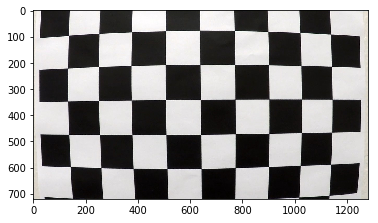

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib inline

#prepare object points
nx = 9
ny = 6

#Read in a calibration image
name = 'camera_cal/calibration1.jpg'
img = mpimg.imread(name)
shape = img.shape[0:2][::-1]
print('Image shape:', shape)
plt.figure()
print('\n\nDistorted image example')
fig = plt.imshow(img)

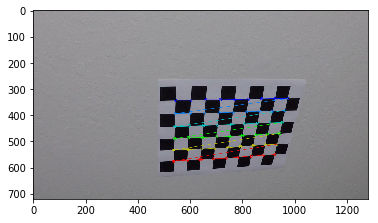

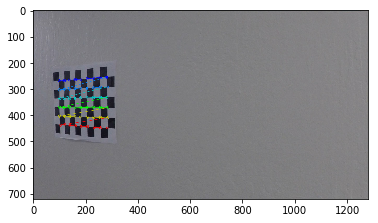

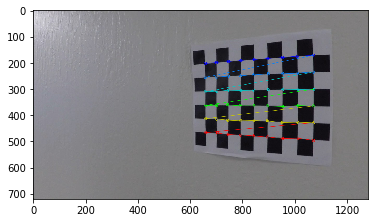

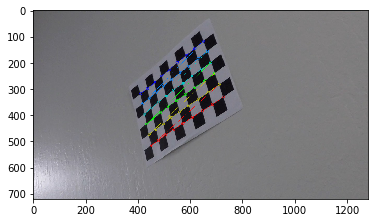

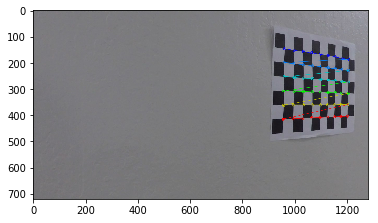

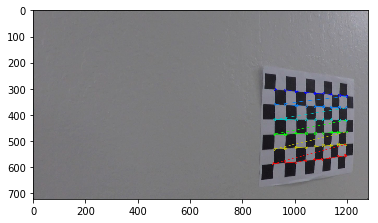

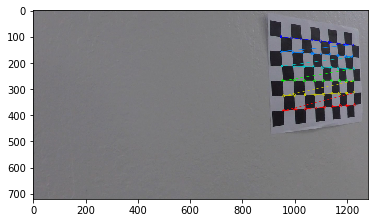

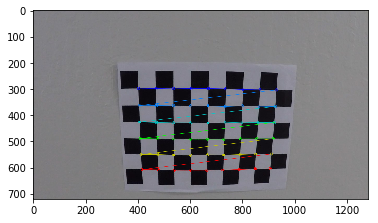

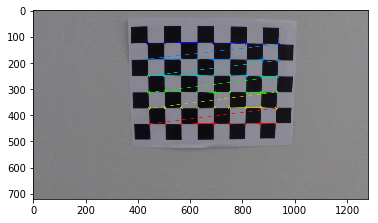

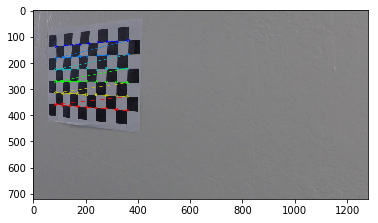

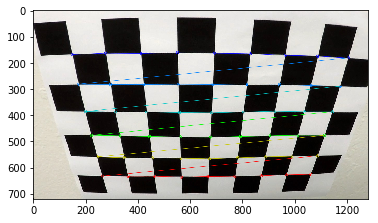

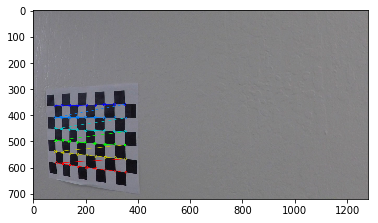

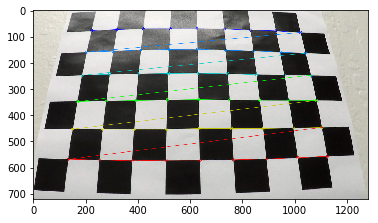

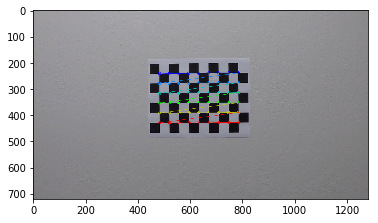

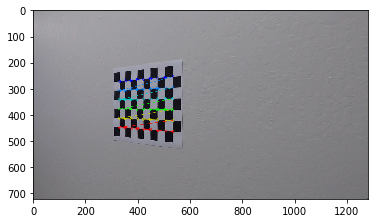

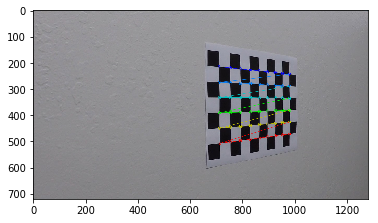

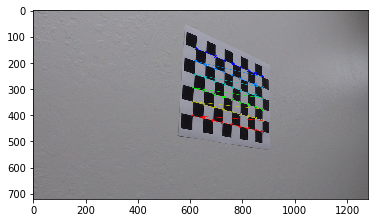

In [2]:
#Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

#Arrays to store object points and image points from all the images

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

#Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,6,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

saved= False
for fname in images:
    # Read in ch image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        #draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        if not saved:
            mpimg.imsave('examples/lines_drawn.jpg', img)
            saved = True
        plt.figure()
        plt.imshow(img)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)

Undistorted chessboard example


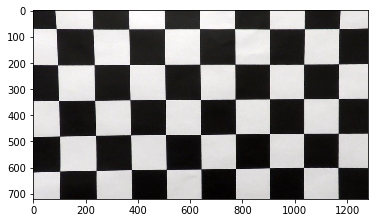

In [3]:
img = mpimg.imread(name)
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


undistorted = undistort(img)
mpimg.imsave('examples/undistorted.jpg', undistorted)
print('Undistorted chessboard example')
fig = plt.imshow(undistorted)

Distorted road image example


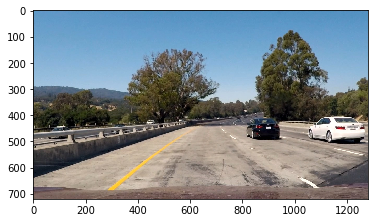

In [4]:
imgs = os.listdir('test_images/')
folder = 'test_images/'
car_image_name = 'test_images/test1.jpg'
car_distorted = mpimg.imread(car_image_name)
car_undistorted = undistort(car_distorted)
plt.figure()
print('Distorted road image example')
plt.imshow(car_distorted)

straight_img = mpimg.imread('test_images/straight_lines1.jpg')
undistorted_straight = undistort(straight_img)
mpimg.imsave('undistorted_straight.jpg', undistorted_straight)

Undistorted road image example


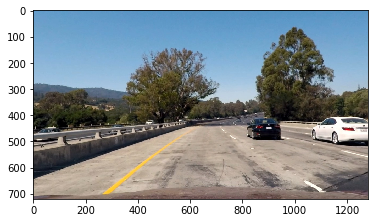

In [5]:
print("Undistorted road image example")
plt.figure()
plt.imshow(car_undistorted)

## Pipeline

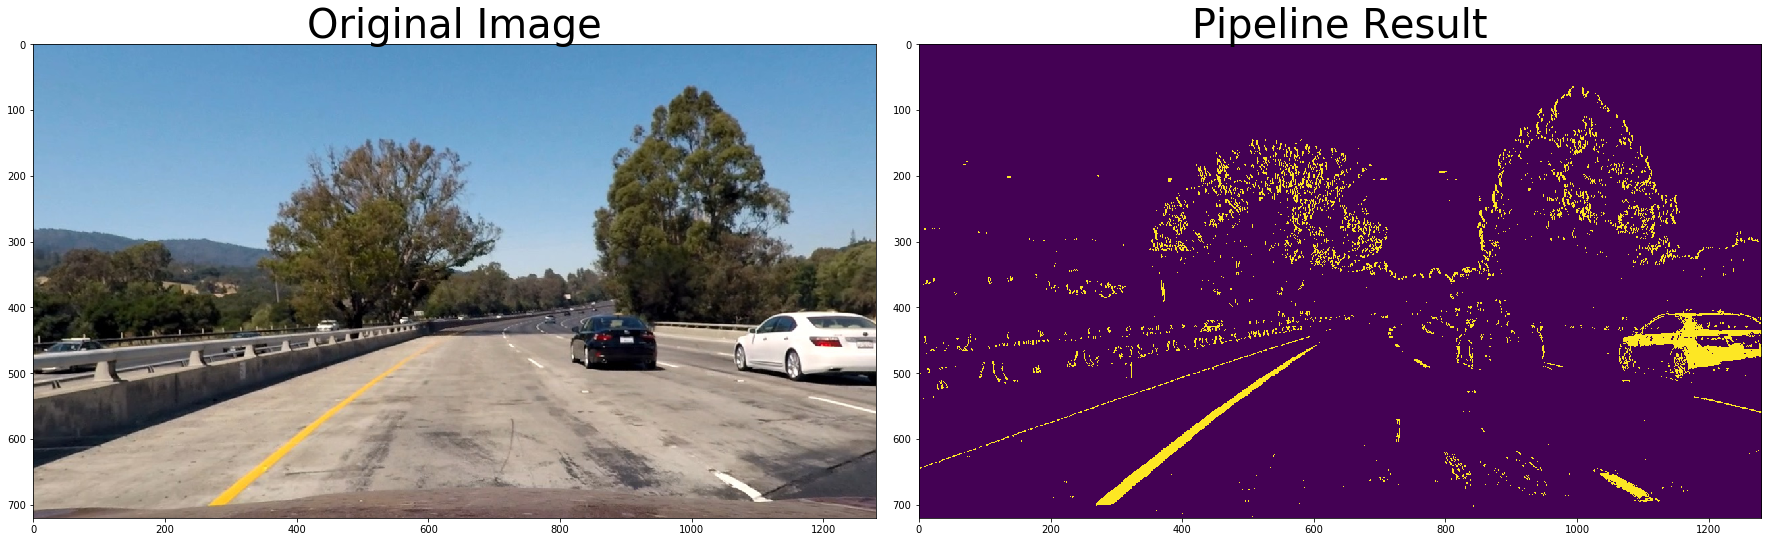

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = car_undistorted

def threshold(img, s_thresh=(140, 255), sx_thresh=(30, 100), rg_thresh = 70):
    img = np.copy(img)
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold RG channel
    r_binary = np.zeros_like(r_channel)
    r_binary[r_channel >= rg_thresh] = 1
    g_binary = np.zeros_like(g_channel)
    g_binary[g_channel >= rg_thresh] = 1
    rg_binary = np.minimum(r_binary, g_binary)
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    color_binary = np.maximum(sxbinary, s_binary)
    final_binary = np.minimum(color_binary, rg_binary)
    return final_binary
    
result = threshold(image)
mpimg.imsave('examples/thresholded.jpg', result)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

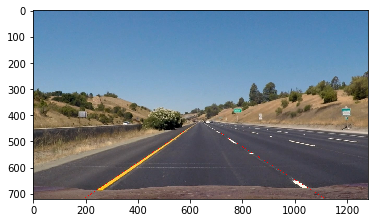

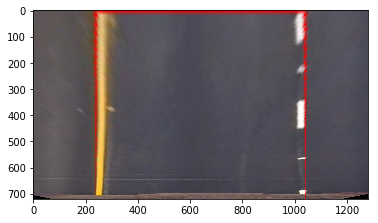

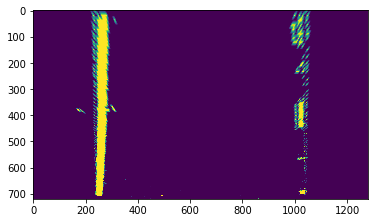

In [7]:
src = np.float32([[192, 720], [578, 460], [704, 460], [1118, 720]])
dst = np.float32([[240, 720], [240, 0], [1040, 0], [1040, 720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warp(img):
    return cv2.warpPerspective(img, M, shape, flags=cv2.INTER_LINEAR)

imgs = os.listdir('test_images/')

img =mpimg.imread(folder + imgs[0])
pts1 = np.int_(src)
pts1 = pts1.reshape((-1,1,2))
masked_img = cv2.polylines(img, [pts1], True, (255, 0, 0))
plt.figure()
plt.imshow(masked_img)
warped = warp(img)
mpimg.imsave('examples/warped.jpg', warped)
warped_thresh = warp(threshold(img))
mpimg.imsave('examples/warped_thresh.jpg', warped_thresh)
plt.figure()
plt.imshow(warped)
plt.figure()
plt.imshow(warped_thresh)


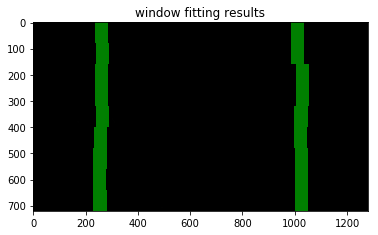

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching


def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin, prev_centroids = None, delta = 20):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
    if prev_centroids is not None:
        m_m = {-1 : max, 1: min, 0 : max}
        centroids = []
        for i in range(len(prev_centroids)):
            lsign = np.sign(window_centroids[i][0] - prev_centroids[i][0])
            rsign = np.sign(window_centroids[i][1] - prev_centroids[i][1])
            
            left = m_m[lsign](prev_centroids[i][0] + lsign * delta, window_centroids[i][0])
            right = m_m[rsign](prev_centroids[i][1] + rsign * delta, window_centroids[i][1])
            centroids.append((left, right))
        return np.array(centroids)
            
    return np.array(window_centroids)

warped = warped_thresh
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
#If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
mpimg.imsave('examples/centroids.jpg',output)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [9]:
ym_per_pix = 30/720
xm_per_pix = 3.7/720

def x_eval(y, poly):
    return int(poly[0] * (y**2) + poly[1] * y + poly[2])

def curve(poly, y_eval):
    return ((1 + (2*poly[0]*y_eval*ym_per_pix + poly[1])**2)**1.5) / np.absolute(2*poly[0])

def line_space(poly):
    return np.array([x_eval(y, poly) for y in ploty])
    
class Line():
    n = 6
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = None
        #average x values of the fitted line over the last n iterations
        self.bestx = np.array([])     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def update(self, y, x):
        self.current_fit = np.polyfit(y, x, 2)
        self.allx = x
        self.ally = y
        newx = line_space(self.current_fit)
        if self.recent_xfitted is not None:
            self.recent_xfitted = np.append([newx], self.recent_xfitted[:Line.n], axis=0)
        else:
            self.recent_xfitted = np.array([newx])
        self.bestx = np.average(self.recent_xfitted, axis=0)
        self.best_fit = np.polyfit(ploty, self.bestx, 2)
        fit_cr = np.polyfit(ploty*ym_per_pix, self.bestx*xm_per_pix, 2)
        self.radius_of_curvature = curve(fit_cr, 719)
        self.line_base_pos = abs(640- x_eval(719, self.best_fit)) * xm_per_pix

        

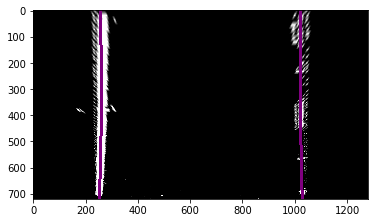

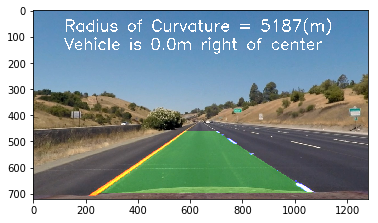

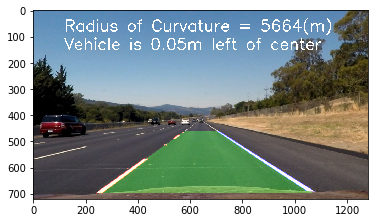

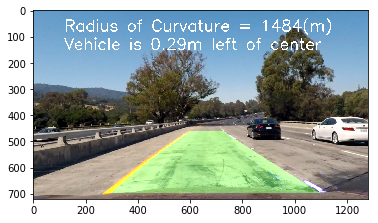

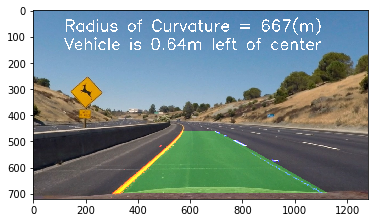

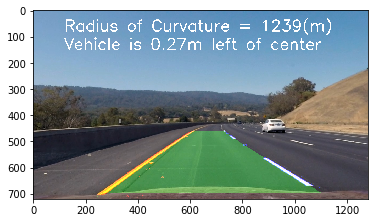

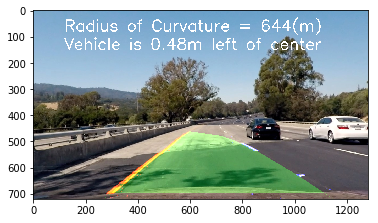

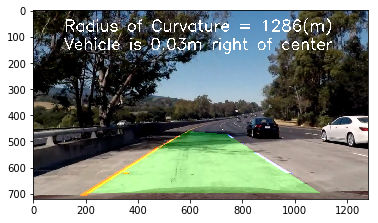

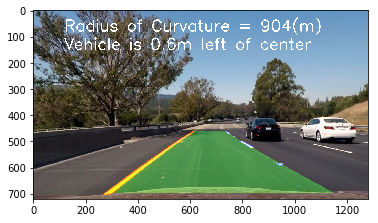

In [10]:
left_lane = Line()
right_lane = Line()
c_centroids = None

def get_pixels(warped_thresh, centroids):
    #Get all nonzero pixels within the windows of a binary image
    pts = np.argwhere(warped_thresh)
    cond = False
    i = 0
    for center in centroids:
        ll, ur = (window_height * i, int(center - window_width/2)), ((window_height * (i+1)), int(center + window_width/2))
        cond = np.logical_or(cond, np.logical_and(ll<=pts, pts<=ur))
        i+=1
    cond = np.all(cond, axis=1)
    pts = pts[np.bool_(cond)]
    return pts[:,0], pts[:,1] # y, x

ploty = np.linspace(0, 719, num = 720)


def draw(warped, undist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    leftx = np.array([x_eval(y, left_lane.best_fit) for y in left_lane.ally])
    rightx = np.array([x_eval(y, right_lane.best_fit) for y in right_lane.ally])
    leftx = np.append(leftx, [x_eval(710, left_lane.best_fit)], axis = 0)
    rightx = np.append(rightx, [x_eval(710, right_lane.best_fit)], axis = 0)
    lefty = np.append(left_lane.ally, [710], axis = 0)
    righty = np.append(right_lane.ally, [710], axis = 0)
    pts_left = np.array([np.transpose(np.vstack([leftx, lefty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, righty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    lanes = np.zeros_like(warped).astype(np.uint8)
    color_lanes = np.dstack((lanes, lanes, lanes))
    for x, y in list(zip(left_lane.allx, left_lane.ally)):
        color_lanes[y][x][0] = 255
    for x, y in list(zip(right_lane.allx, right_lane.ally)):
        color_lanes[y][x][2] = 255
    color_lanes = cv2.warpPerspective(color_lanes, Minv, (image.shape[1], image.shape[0]))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    result = cv2.addWeighted(result, 1, color_lanes, 1, 0)
    return result

def add_text(img):
    lane_curve = (left_lane.radius_of_curvature + right_lane.radius_of_curvature) / 2
    dist_from_center = left_lane.line_base_pos - right_lane.line_base_pos
    text1 = "Radius of Curvature = " + str(int(lane_curve)) + "(m)"
    if dist_from_center < 0:
        l_or_r = "left"
    else:
        l_or_r = "right"
    dist_from_center = abs(dist_from_center)
    text2 = "Vehicle is " + str(round(dist_from_center, 2)) + "m " + l_or_r + " of center"
    cv2.putText(img, text1, (120,80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    cv2.putText(img, text2, (120,150), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    return img

def pipeline(img):
    undist = undistort(img)
    thresh = threshold(undist)
    warped = warp(thresh)
    global c_centroids
    c_centroids = find_window_centroids(warped, window_width, window_height, margin, prev_centroids = c_centroids)
    left_centers, right_centers = c_centroids[:,0], c_centroids[:,1]
    lefty, leftx = get_pixels(warped, left_centers)
    righty, rightx = get_pixels(warped, right_centers)
    left_lane.update(lefty, leftx)
    right_lane.update(righty, rightx)
    drawn = draw(warped, undist)
    with_text = add_text(drawn)
    return with_text

saved = False

for fname in imgs:
    left_lane = Line()
    right_lane = Line()
    c_centroids= None
    img = mpimg.imread("test_images/" + fname)
    result = pipeline(img)
    if not saved:
        new_warped = np.dstack((warped, warped, warped))
        pts = np.array(list(zip(np.int_(left_lane.bestx), np.int_(ploty))))
        pts = pts.reshape((-1,1,2))
        left_filled = cv2.polylines(new_warped, pts, True, (128, 0, 128), thickness = 10)
        pts = np.array(list(zip(np.int_(right_lane.bestx), np.int_(ploty))))
        pts = pts.reshape((-1,1,2))
        right_filled = cv2.polylines(left_filled, pts, True, (128, 0, 128), thickness = 10)
        plt.figure()
        plt.imshow(right_filled)
        mpimg.imsave('examples/poly.jpg', warped)
        saved = True
    plt.figure()
    plt.imshow(result)
    mpimg.imsave('output_images/' + fname, result)
    

In [11]:
from IPython.display import HTML

left_lane = Line()
right_lane = Line()
c_centroids = None
    
def edit(fin, fout, function):
    cap = cv2.VideoCapture(fin)
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc('D', 'I', 'V', 'X')
    out = cv2.VideoWriter(fout, fourcc, 25.0, frameSize=(1280, 720))
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            edited = function(frame)
            # write the flipped frame
            out.write(edited)
            cv2.imshow('Frame',edited)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break
    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

edit('project_video.mp4', 'edited.mp4', pipeline)

## Annotated video
<video controls src="edited.mp4" />